In [1]:
import numpy as np
import os
import pandas as pd
import scipy as sc
import warnings
import csv
from itertools import groupby
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import recall_score as rec, precision_score as pre, f1_score as f1, accuracy_score as acc

In [2]:
#file_name = 'sig_extract/a.fa.hmmpfam2'
file_name = 'sig_extract/Adomain_Substrate.fa.hmmpfam2'

In [3]:
# Hamming Distance between two strings
def hamming(str1, str2):
    ret = 0
    for (a,b) in zip(str1, str2):
        ret += (a!=b)
    return ret

# Normalized Hamming Distance between two strings based on string length
def hamming_frac(str1, str2):
    return hamming(str1, str2)/min(len(str1), len(str2))

#print(hamming('aaaa', 'baab'))
#print(hamming_frac('aaaa', 'baab'))

In [4]:
def remove_multiple_spaces(string, remove_lead_trail=True):
    if remove_lead_trail:
        string = string.strip()
    while '  ' in string:
        string = string.replace('  ', ' ')
    return string

def get_state(state, line, print_state_transitions=False):
    #print(line)
    #print('incoming state ', state)
    newstate = ''
    if state in ['init', 'parsing']:
        if line.startswith('//') or line.startswith('- - - -'):
            newstate = 'recognise'
    elif state == 'recognise':
        if line.startswith('Alignments of top'):
            newstate = 'parsing'

    if print_state_transitions:
        if newstate != '':
            print('Changed state from ',state,' to ', newstate)
        else:
            newstate = state
    
    if newstate == '':
        newstate = state
    return newstate

def parse_hmmsearch_output(lines, hmmfiles):
    align_dict = {}
    align_code_dict = {}
    score_dict = {}
    detail_dict = {}
    line_score_idx = 0
    
    
    line_idx = 0
    line_align_idx = 0
    Id = ''
    state = 'init'
    curr_hmm = ''
    #print(lines)
    
    for line in lines:
        line_idx += 1        
        state = get_state(state, line)
        
        if state == 'recognise':
            if line.startswith('Query sequence'):
                Id = line.split(': ')[1].strip('\n')
                #print('set id to ',Id)
                detail_dict[Id] = {}

        elif state == 'parsing':
            hmmheader = np.asarray([line.startswith(hmmfile) for hmmfile in hmmfiles]).any()
            if hmmheader:
                line_align_idx = line_idx
                curr_hmm = line.split(':')[0]
                #print(curr_hmm)
                split = line.split(' ')
                #print(split)
                score_idx = split.index('score')+1
                from_idx = split.index('from')+1
                to_idx = split.index('to')+1
                detail_dict[Id][curr_hmm] = {'score':float(split[score_idx].strip(',')),'from': int(split[from_idx]),
                                             'to': int(split[to_idx].strip(':')), 'top':'', 'bottom':''}
                #print(detail_dict)
            elif line.startswith(' '):
                #print(line_idx, line_align_idx, line)
                if (line_idx - line_align_idx) % 4 == 1:
                    detail_dict[Id][curr_hmm]['top'] += remove_multiple_spaces(line).strip('*-><')
                elif (line_idx - line_align_idx) % 4 == 3:
                    detail_dict[Id][curr_hmm]['bottom'] += remove_multiple_spaces(line).split()[2]
        
    return detail_dict

def parse_hmmsearch_output_from_file(filename, hmmfile):
    with open(filename, 'r') as file:
        content = file.readlines()
    return parse_hmmsearch_output(content, hmmfile)

In [5]:
detail_dict = parse_hmmsearch_output_from_file(file_name, ['aa-activating-core.198-334', 'aroundLys517'])

In [6]:
def get_best_alignment(mydict):
    #print(mydict)
    ret_dict = {}
    for Id in mydict:
        #print(Id)
        start = False
        score = -1
        best_hmm = ''
        for hmm in mydict[Id]:
            #print(hmm, best_hmm)
            if best_hmm == '' or score < mydict[Id][hmm]['score']:
                best_hmm = hmm
        ret_dict[Id] = mydict[Id][best_hmm].copy()
        ret_dict[Id]['hmm'] = best_hmm
        
    return ret_dict

best_align_dict = get_best_alignment(detail_dict)

In [7]:
def get_hmm_alignment(mydict, hmm):
    ret_dict = {}
    for key in mydict:
        try:
            ret_dict[key] = mydict[key][hmm].copy()
        except:
            print('Could not get',hmm,' for Id',key)
    return ret_dict

a_align_dict = get_hmm_alignment(detail_dict, 'aa-activating-core.198-334')

In [8]:
def removetopindels(indict, print_change=False):
    mydict = indict.copy()
    for Id in mydict:
        top_tmp = ''
        bot_tmp = ''
        idx = mydict[Id]['from']
        idx_list = []
        for a,b in zip(mydict[Id]['top'], mydict[Id]['bottom']):
            if a != '.':
                top_tmp += a
                bot_tmp += b
                if b == '-':
                    idx_list.append(idx-0.5)
                else:
                    idx_list.append(idx)
            if b != '-':
                idx += 1
        if print_change and mydict[Id]['top'] != top_tmp:
            print('Id:',Id,' top changed from ',mydict[Id]['top'], 'to', top_tmp)
        if print_change and mydict[Id]['bottom'] != bot_tmp:
            print('Id:',Id,' bottom changed from ',mydict[Id]['bottom'], 'to', bot_tmp)
        mydict[Id]['top'] = top_tmp
        mydict[Id]['bottom'] = bot_tmp
        assert(len(mydict[Id]['bottom']) == len(idx_list))
        mydict[Id]['idx_list'] = idx_list.copy()
    return mydict

a_align_dict_no_indel = removetopindels(a_align_dict)

In [9]:
def extractCharacters(Id, target, source, source_idx_list, pattern, idxs) :
    assert len(source) == len(source_idx_list)
    try:
        start = target.index(pattern)
    except:
        print('Problem at Id ', Id, ' pattern ', pattern, ' target ', target)
    ret = ''
    pos = []
    for idx in idxs:
        ret += source[start+idx]
        pos.append(source_idx_list[start+idx])
    return ret, pos

In [10]:
#extractCharacters('gig', 'rty', 'ggui', [345,346,349,350], 't', [2])

In [11]:
def extract_sig(Id, top, bottom, idx_list):
    try:
        s1, p1 = extractCharacters(Id, top, bottom, idx_list, "KGVmveHrnvvnlvkwl", [12, 15, 16])
        s2, p2 = extractCharacters(Id, top, bottom, idx_list, "LqfssAysFDaSvweifgaLLnGgt", [3,8,9,10,11,12,13,14,17])
        s3, p3 = extractCharacters(Id, top, bottom, idx_list, "iTvlnltPsl", [4,5])
        s4, p4 = extractCharacters(Id, top, bottom, idx_list, "LrrvlvGGEaL", [4,5,6,7,8])
        s5, p5 = extractCharacters(Id, top, bottom, idx_list, "liNaYGPTEtTVcaTi", [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

        return s1+s2+s3+s4+s5, p1+p2+p3+p4+p5
    except:
        return '', []
def extract_sig_dict(mydict):
    ret_dict = {}
    #ret_dict = mydict.copy()
    for Id in mydict:
        ret_dict[Id] = {}
        ret_dict[Id]['sig'], ret_dict[Id]['pos'] = extract_sig(Id, mydict[Id]['top'], mydict[Id]['bottom'], mydict[Id]['idx_list'])
        #ret_dict[Id]['sig'] = extract_sig(Id, mydict[Id]['top'], mydict[Id]['bottom'])
    return ret_dict

In [12]:
sig_dict = extract_sig_dict(a_align_dict_no_indel)

In [13]:
nrps_res_file = 'Adomain_Substrate.report'
df_nrps_res = pd.read_csv(nrps_res_file, delimiter='\t')
test_sig = list(df_nrps_res['8A-signature'])
test_id = list(df_nrps_res['#sequence-id'])

In [14]:
# Check if NRPS result matches extracted
unmatched = 0
for i, s in zip(test_id, test_sig):
    sig = sig_dict[i]['sig']
    if s!=sig:
        print(s, sig)
        unmatched += 1
if unmatched:
    print('All signatures from',nrps_res_file,'matched to our generated signatures')
else:
    print(unmatched,' signatures from', nrps_res_file, 'did not match to our generated ones')

0  signatures from Adomain_Substrate.report did not match to our generated ones


In [15]:
#for Id in sig_dict:
    #print(Id,',',sig_dict[Id]['sig'],',',sig_dict[Id]['pos'])

In [16]:
#print(sig_dict['O30409_6|L'])

In [17]:
def check_for_gap_sig(my_sig_dict, print_gap_sig = False):
    count = 0
    for Id in my_sig_dict:
        pos = my_sig_dict[Id]['pos']
        pos_frac_sum = sum([p-float(int(p)) for p in pos])
        if pos_frac_sum > 0:
            if print_gap_sig:
                print(Id, ':', my_sig_dict[Id]['sig'])
                print(Id, ':', pos)
            count += 1
    print('There are',count,'signatures with gap among',len(sig_dict),'extracted signatures')

check_for_gap_sig(sig_dict)

There are 24 signatures with gap among 1546 extracted signatures


In [18]:
aa_alias_dict = {'A': 'Ala', 'V': 'Val', 'L': 'Leu', 'I': 'Ile', 'P': 'Pro', 'F': 'Phe', 'W': 'Trp', 'M': 'Met',
'K': 'Lys', 'R': 'Arg', 'H': 'His', 'G': 'Gly', 'S': 'Ser', 'T': 'Thr', 'C': 'Cys', 'Y': 'Tyr',
'N': 'Asn', 'Q': 'Gln', 'D': 'Asp', 'E': 'Glu'}

In [19]:
def get_rev_dict(mydict, lowercase=True):
    ret_dict = {}
    ret_inv_dict = {}
    for key in mydict:
        if lowercase:
            ret_dict[key.lower()] = mydict[key].lower()
            ret_inv_dict[mydict[key].lower()] = key.lower()
        else:
            ret_dict[key] = mydict[key]
            ret_inv_dict[mydict[key]] = key
    return ret_dict, ret_inv_dict

In [20]:
aa_alias_dict_lower, inv_aa_alias_dict_lower = get_rev_dict(aa_alias_dict)

In [21]:
pdb_filename = '398987.pdb.modified'

In [22]:
def parse_pdb_output(lines):
    mod_lines = []
    N_dict = {}
    N_dict['loc'] = {}
    N_dict['x'] = {}
    N_dict['y'] = {}
    N_dict['z'] = {}
    for line in lines:
        #print(len(line))
        if line.startswith('ATOM'):
            mod_lines.append(remove_multiple_spaces(line.strip('\n')))
            line_split = line.split()
            if line_split[2] == 'N':
                N_dict['loc'][int(line_split[4])] = inv_aa_alias_dict_lower[line_split[3].lower()].upper()
                N_dict['x'][int(line_split[4])] = float(line_split[5])
                N_dict['y'][int(line_split[4])] = float(line_split[6])
                N_dict['z'][int(line_split[4])] = float(line_split[7])
                #print(line)
    return N_dict

def parse_pdb_output_from_file(filename):
    with open(filename, 'r') as file:
        content = file.readlines()
    return parse_pdb_output(content)

In [23]:
#print(parse_pdb_output_from_file('398987.pdb'))

In [24]:
pdb_content = parse_pdb_output_from_file(pdb_filename)
#pdb_content = parse_pdb_output_from_file('398987.pdb')
'''
N_dict = {}

for line in pdb_content:
    all_good = True
    #print(line)
    line_split = line.split()
    try:
        assert len(line_split) == 11
    except:
        all_good = False
        print('Line<',line,'> does not have required spacing')
    if line_split[2] == 'N':
        N_dict[int(line_split[4])] = inv_aa_alias_dict_lower[line_split[3].lower()].upper()
'''

"\nN_dict = {}\n\nfor line in pdb_content:\n    all_good = True\n    #print(line)\n    line_split = line.split()\n    try:\n        assert len(line_split) == 11\n    except:\n        all_good = False\n        print('Line<',line,'> does not have required spacing')\n    if line_split[2] == 'N':\n        N_dict[int(line_split[4])] = inv_aa_alias_dict_lower[line_split[3].lower()].upper()\n"

In [25]:
def get_seq_from_pos(pos_list, ref_dict, Id, offset=0, print_error=True, convert_to_float=False):
    ret = []
    try:
        for pos in pos_list:
            ret.append(float(ref_dict[int(pos + offset)]) if convert_to_float else ref_dict[int(pos + offset)])
    except:
        if print_error:
            print('some error occured with Id',Id,'list',pos_list)
    return ret if convert_to_float else ''.join(ret)

hamming_frac(get_seq_from_pos(sig_dict['O30409_6|L']['pos'], pdb_content['loc'], 'O30409_6|L'), sig_dict['O30409_6|L']['sig'])

0.0

In [26]:
basedir_raptorX = 'raptorX'
files_basedir_raptorX = os.listdir(basedir_raptorX)
req_files_basedir_raptorX = []
N_dict = {}

for file in files_basedir_raptorX:
    file_abs_path = os.path.abspath(os.path.join(basedir_raptorX, file))
    #print(file, file_abs_path)
    if os.path.isdir(file_abs_path):
        files_subdir = os.listdir(file_abs_path)
        for file_subdir in files_subdir:
            file_subdir_abs_path = os.path.abspath(os.path.join(file_abs_path, file_subdir))
            if os.path.isdir(file_subdir_abs_path):
                #print(os.listdir(file_subdir_abs_path))
                files_subsubdir = os.listdir(file_subdir_abs_path)
                #print(files_subsubdir)
                fasta_files = list(filter(lambda x: x.endswith('.fasta'), files_subsubdir))
                pdb_files = list(filter(lambda x: x.endswith('.pdb'), files_subsubdir))
                if len(fasta_files) > 0 and len(pdb_files) > 0:
                    fasta_file = os.path.join(file_subdir_abs_path, fasta_files[0])
                    #print(fasta_file)
                    with open(fasta_file, 'r') as f:
                        contents = f.readlines()
                        Id_orig = contents[0].strip('>\n')
                        Id = '_'.join(Id_orig.split('_')[:-1]) + '|' + Id_orig.split('_')[-1]
                        #print(Id_orig, Id)
                        N_dict[Id] = {}
                    pdb_file = os.path.join(file_subdir_abs_path, pdb_files[0])
                    #print(fasta_file, pdb_file)
                    N_dict[Id] = parse_pdb_output_from_file(pdb_file)
                    #print(N_dict)

In [27]:
'''
for key in N_dict:
    print(hamming_frac(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['loc'], key), sig_dict[key]['sig']))
    print(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['loc'], key), sig_dict[key]['sig'])
    print(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['x'], key, convert_to_float=True))
'''

"\nfor key in N_dict:\n    print(hamming_frac(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['loc'], key), sig_dict[key]['sig']))\n    print(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['loc'], key), sig_dict[key]['sig'])\n    print(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['x'], key, convert_to_float=True))\n"

In [28]:
N_dict['O30409_6|L'].keys()

dict_keys(['loc', 'x', 'y', 'z'])

In [29]:
# Read Signatures and z scores
csv_name = "labeled_sigs"
z_score_csv_name = "z_score_aa_001"
df_original = pd.read_csv(csv_name, delimiter='\t')
z_scores_df = pd.read_csv(z_score_csv_name, delimiter=' ')

In [30]:
# Prep for hardcoded values
m=26
nrow = 12
D = np.zeros((nrow, m))
D1 = D[0 ,:]
D2 = D[1 ,:]
D3 = D[2 ,:]
D4 = D[3 ,:]
D5 = D[4 ,:]
D6 = D[5 ,:]
D7 = D[6 ,:]
D8 = D[7 ,:]
D9 = D[8 ,:]
D10 = D[9 ,:]
D11 = D[10 ,:]
D12 = D[11 ,:]

In [31]:
# Hard coded values, taken from NRPSPredictor2 github

#1 aa-alpha-helix.aaindex
D1[0]=1.420;D1[1]=0.000;D1[2]=0.700;D1[3]=1.010;D1[4]=1.510;D1[5]=1.130;D1[6]=0.570;D1[7]=1.000;D1[8]=1.080;D1[9]=0.000;D1[10]=1.160;D1[11]=1.210;D1[12]=1.450;D1[13]=0.670;D1[14]=0.000;D1[15]=0.570;D1[16]=1.110;D1[17]=0.980;D1[18]=0.770;D1[19]=0.830;D1[20]=0.000;D1[21]=1.060;D1[22]=1.080;D1[23]=0.000;D1[24]=0.690;D1[25]=0.000;
#2 aa-beta-sheet.aaindex
D2[0]=0.830;D2[1]=0.000;D2[2]=1.190;D2[3]=0.540;D2[4]=0.370;D2[5]=1.380;D2[6]=0.750;D2[7]=0.870;D2[8]=1.600;D2[9]=0.000;D2[10]=0.740;D2[11]=1.300;D2[12]=1.050;D2[13]=0.890;D2[14]=0.000;D2[15]=0.550;D2[16]=1.100;D2[17]=0.930;D2[18]=0.750;D2[19]=1.190;D2[20]=0.000;D2[21]=1.700;D2[22]=1.370;D2[23]=0.000;D2[24]=1.470;D2[25]=0.000;
#3 aa-beta-turn.aaindex
D3[0]=0.740;D3[1]=0.000;D3[2]=0.960;D3[3]=1.520;D3[4]=0.950;D3[5]=0.660;D3[6]=1.560;D3[7]=0.950;D3[8]=0.470;D3[9]=0.000;D3[10]=1.190;D3[11]=0.500;D3[12]=0.600;D3[13]=1.460;D3[14]=0.000;D3[15]=1.560;D3[16]=0.960;D3[17]=1.010;D3[18]=1.430;D3[19]=0.980;D3[20]=0.000;D3[21]=0.590;D3[22]=0.600;D3[23]=0.000;D3[24]=1.140;D3[25]=0.000;
#4 aa-hydrogenbond.aaindex
D4[0]=0.000;D4[1]=0.000;D4[2]=0.000;D4[3]=1.000;D4[4]=1.000;D4[5]=0.000;D4[6]=0.000;D4[7]=1.000;D4[8]=0.000;D4[9]=0.000;D4[10]=2.000;D4[11]=0.000;D4[12]=0.000;D4[13]=2.000;D4[14]=0.000;D4[15]=0.000;D4[16]=2.000;D4[17]=4.000;D4[18]=1.000;D4[19]=1.000;D4[20]=0.000;D4[21]=0.000;D4[22]=1.000;D4[23]=0.000;D4[24]=1.000;D4[25]=0.000;
#5 aa-hydrophobicity-neu1.aaindex
D5[0]=0.060;D5[1]=0.000;D5[2]=-0.560;D5[3]=0.970;D5[4]=0.850;D5[5]=-0.990;D5[6]=0.320;D5[7]=0.150;D5[8]=-1.000;D5[9]=0.000;D5[10]=1.000;D5[11]=-0.830;D5[12]=-0.680;D5[13]=0.700;D5[14]=0.000;D5[15]=0.450;D5[16]=0.710;D5[17]=0.800;D5[18]=0.480;D5[19]=0.380;D5[20]=0.000;D5[21]=-0.750;D5[22]=-0.570;D5[23]=0.000;D5[24]=-0.350;D5[25]=0.000;
#6 aa-hydrophobicity-neu2.aaindex
D6[0]=-0.250;D6[1]=0.000;D6[2]=-0.400;D6[3]=-0.080;D6[4]=-0.100;D6[5]=0.180;D6[6]=-0.320;D6[7]=-0.030;D6[8]=-0.030;D6[9]=0.000;D6[10]=0.320;D6[11]=0.050;D6[12]=-0.010;D6[13]=-0.060;D6[14]=0.000;D6[15]=0.230;D6[16]=-0.020;D6[17]=0.190;D6[18]=-0.150;D6[19]=-0.100;D6[20]=0.000;D6[21]=-0.190;D6[22]=0.310;D6[23]=0.000;D6[24]=0.400;D6[25]=0.000;
#7 aa-hydrophobicity-neu3.aaindex
D7[0]=0.250;D7[1]=0.000;D7[2]=-0.140;D7[3]=0.080;D7[4]=-0.050;D7[5]=0.150;D7[6]=0.280;D7[7]=-0.100;D7[8]=0.100;D7[9]=0.000;D7[10]=0.110;D7[11]=0.010;D7[12]=0.040;D7[13]=0.170;D7[14]=0.000;D7[15]=0.410;D7[16]=0.120;D7[17]=-0.410;D7[18]=0.230;D7[19]=0.290;D7[20]=0.000;D7[21]=0.030;D7[22]=0.340;D7[23]=0.000;D7[24]=-0.020;D7[25]=0.000;
#8 aa-isoelectric.aaindex
D8[0]=6.000;D8[1]=0.000;D8[2]=5.050;D8[3]=2.770;D8[4]=3.220;D8[5]=5.480;D8[6]=5.970;D8[7]=7.590;D8[8]=6.020;D8[9]=0.000;D8[10]=9.740;D8[11]=5.980;D8[12]=5.740;D8[13]=5.410;D8[14]=0.000;D8[15]=6.300;D8[16]=5.650;D8[17]=10.760;D8[18]=5.680;D8[19]=5.660;D8[20]=0.000;D8[21]=5.960;D8[22]=5.890;D8[23]=0.000;D8[24]=5.660;D8[25]=0.000;
#9 aa-polar-grantham.aaindex
D9[0]=8.100;D9[1]=0.000;D9[2]=5.500;D9[3]=13.000;D9[4]=12.300;D9[5]=5.200;D9[6]=9.000;D9[7]=10.400;D9[8]=5.200;D9[9]=0.000;D9[10]=11.300;D9[11]=4.900;D9[12]=5.700;D9[13]=11.600;D9[14]=0.000;D9[15]=8.000;D9[16]=10.500;D9[17]=10.500;D9[18]=9.200;D9[19]=8.600;D9[20]=0.000;D9[21]=5.900;D9[22]=5.400;D9[23]=0.000;D9[24]=6.200;D9[25]=0.000;
#10 aa-polar-radzicka.aaindex
D10[0]=-0.060;D10[1]=0.000;D10[2]=1.360;D10[3]=-0.800;D10[4]=-0.770;D10[5]=1.270;D10[6]=-0.410;D10[7]=0.490;D10[8]=1.310;D10[9]=0.000;D10[10]=-1.180;D10[11]=1.210;D10[12]=1.270;D10[13]=-0.480;D10[14]=0.000;D10[15]=1.100;D10[16]=-0.730;D10[17]=-0.840;D10[18]=-0.500;D10[19]=-0.270;D10[20]=0.000;D10[21]=1.090;D10[22]=0.880;D10[23]=0.000;D10[24]=0.330;D10[25]=0.000;
#11 aa-polar-zimmerman.aaindex
D11[0]=0.000;D11[1]=0.000;D11[2]=1.480;D11[3]=49.700;D11[4]=49.900;D11[5]=0.350;D11[6]=0.000;D11[7]=51.600;D11[8]=0.130;D11[9]=0.000;D11[10]=49.500;D11[11]=0.130;D11[12]=1.430;D11[13]=3.380;D11[14]=0.000;D11[15]=1.580;D11[16]=3.530;D11[17]=52.000;D11[18]=1.670;D11[19]=1.660;D11[20]=0.000;D11[21]=0.130;D11[22]=2.100;D11[23]=0.000;D11[24]=1.610;D11[25]=0.000;
#12 aa-volume.aaindex
D12[0]=90.000;D12[1]=0.000;D12[2]=103.300;D12[3]=117.300;D12[4]=142.200;D12[5]=191.900;D12[6]=64.900;D12[7]=160.000;D12[8]=163.900;D12[9]=0.000;D12[10]=167.300;D12[11]=164.000;D12[12]=167.000;D12[13]=124.700;D12[14]=0.000;D12[15]=122.900;D12[16]=149.400;D12[17]=194.000;D12[18]=95.400;D12[19]=121.500;D12[20]=0.000;D12[21]=139.000;D12[22]=228.200;D12[23]=0.000;D12[24]=197.000;D12[25]=0.000;



In [32]:
# Map Amino acid abbreviations with indices of D[i, :]

aa2ind_map = {}
aa2ind_map['A'] = 0
aa2ind_map['R'] = 17
aa2ind_map['D'] = 3
aa2ind_map['N'] = 13
aa2ind_map['C'] = 2
aa2ind_map['E'] = 4
aa2ind_map['Q'] = 16
aa2ind_map['G'] = 6
aa2ind_map['H'] = 7
aa2ind_map['I'] = 8
aa2ind_map['L'] = 11
aa2ind_map['K'] = 10
aa2ind_map['M'] = 12
aa2ind_map['F'] = 5
aa2ind_map['P'] = 15
aa2ind_map['S'] = 18
aa2ind_map['T'] = 19
aa2ind_map['W'] = 22
aa2ind_map['Y'] = 24
aa2ind_map['V'] = 21

In [33]:
# Dictionary to store 15 dimensional vector values for each amino acid

aa_dict = {}
for i, row in z_scores_df.iterrows():
    aa_dict[row['aa_short']] = [row['z1'], row['z2'], row['z3'], ] # Store z values
    aa_dict[row['aa_short']].extend(D[:, aa2ind_map[row['aa_short']]]) # Store rest of the 12 hard-coded values


In [34]:
# Create index to value map and value to index map from a list using list index
def get_dict_from_list(mylist):
    assert len(mylist) > 0
    idx_to_value_dict = {}
    value_to_idx_dict = {}
    for i in range(len(mylist)):
        idx_to_value_dict[i] = mylist[i]
        value_to_idx_dict[mylist[i]] = int(i)
    return idx_to_value_dict, value_to_idx_dict

# Get index-value maps for substrates
sub_vocab_set = set(df_original['sub'].tolist())
sub_vocab_list = list(sub_vocab_set)
sub_idx_to_value_dict, sub_value_to_idx_dict = get_dict_from_list(sub_vocab_list)

In [35]:
# Remove the entries with only one substrate occurence
df_cnt_filtered = df_original.groupby('sub').filter(lambda x: len(x) > 1)
print("Reduced data size from ",len(df_original)," to ", len(df_cnt_filtered), " due to count filtering")

Reduced data size from  454  to  429  due to count filtering


In [36]:
# Re-Create substrate index-value maps after removing the substrates with count 1

sub_vocab_set = set(df_cnt_filtered['sub'].tolist())
sub_vocab_list = list(sub_vocab_set)
sub_idx_to_value_dict, sub_value_to_idx_dict = get_dict_from_list(sub_vocab_list)

In [37]:
# Given a signature of amino acids(34 aa long), construct the 34x15=510 dimentional representation
def get_encoding(signature):
    ret = []
    for i in signature:
        ret.extend(aa_dict[i])
    return np.asarray(ret)


In [38]:
def list_concat_zip3(l1, l2, l3):
    assert len(l1) == len(l2)
    assert len(l1) == len(l3)
    ret = []
    for idx in range(len(l1)):
        ret.append(l1[idx])
        ret.append(l2[idx])
        ret.append(l3[idx])
    return np.asarray(ret)

In [39]:
#list_concat_zip3([1, 2, 3, 4], [5, 6, 7, 8], [10, 11, 12, 13])

In [40]:
# Format the data
sig_len = 34
raw_data = []
data_np = []
label_np = []
j=0
#for i, row in df_cnt_filtered.iterrows():
    #print((row['sub']))
    #assert len(row['sig']) == sig_len
    #raw_data.append(row['sig'])
    #data_np.append(get_encoding(row['sig']))
    #label_np.append(sub_value_to_idx_dict[row['sub']])
    #j+=1

for key in N_dict:
    #print(key, sig_dict[key]['sig'])
    #print(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['x'], key, convert_to_float=True))
    raw_data.append(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['loc'], key))
    x_data = get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['x'], key, convert_to_float=True)
    y_data = get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['y'], key, convert_to_float=True)
    z_data = get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['z'], key, convert_to_float=True)
    #data_np.append(np.asarray(list(get_encoding(get_seq_from_pos(sig_dict[key]['pos'], N_dict[key]['loc'], key)))+x_data+y_data+z_data))
    #data_np.append(np.asarray(x_data+y_data+z_data))
    data_np.append(list_concat_zip3(x_data, y_data, z_data))
    sub = aa_alias_dict_lower[key.split('|')[1].lower()]
    label_np.append(sub_value_to_idx_dict[sub])
    j += 1

data_np = np.asarray(data_np)
data_np_orig = data_np.copy()
label_np = np.asarray(label_np).astype('int')
raw_data = np.array(raw_data)

In [41]:
, n_data = data_np.shape
new_data_np = []
ref = data_np[0].copy().reshape(34, 3)

for np_data in data_np:
    new_data_np.append(np.matmul(np_data.reshape(34, 3), sc.linalg.orth(np.matmul(np.linalg.pinv(np_data.reshape(34, 3)), ref))).reshape(-1))
data_np = np.asarray(new_data_np)

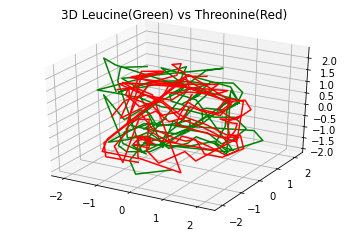

In [42]:
fig = plt.figure()
ax = fig.gca(projection='3d')
c_range = ['blue','red','green','cyan','magenta','black','yellow','white',]
n_points = len(data_np)
#n_points = 7
idx_iter = range(n_points)
idx_iter = [3, 19, 34, 6, 49, 45, 67, 73]

for idx in idx_iter:
    x = data_np[idx].copy().reshape(34, 3)[:, 0]
    y = data_np[idx].copy().reshape(34, 3)[:, 1]
    z = data_np[idx].copy().reshape(34, 3)[:, 2]
    #print(np.std(x), np.std(y), np.std(z))
    #print(np.mean(x), np.mean(y), np.mean(z))
    
    #'''
    x -= np.mean(x)
    x /= np.std(x)
    y -= np.mean(y)
    y /= np.std(y)
    z -= np.mean(z)
    z /= np.std(z)
    #'''
    #print(np.std(x), np.std(y), np.std(z))
    #print(np.mean(x), np.mean(y), np.mean(z))
    ax.plot(x, y, z, c_range[2] if sub_idx_to_value_dict[label_np[idx]] == 'leu' else c_range[1])
    #ax.plot(x, y, z, c_range[idx])
    #print(label_np[idx])

plt.title('3D Leucine(Green) vs Threonine(Red)')
plt.savefig('Leucine_Threonine_'+str(len(idx_iter))+'_3D_'+str(int(np.random.random()*50000))+'.png', dpi=400)
plt.show()

In [43]:
#data_np_orig[0].reshape(34, 3)
#label_np

In [44]:
#sub_idx_to_value_dict
#str(int(np.random.random()*50000))

In [45]:
#d = data_np[0].reshape(34, 3)
#ref = data_np[0].reshape(34, 3)
#print(sc.linalg.orth(np.matmul(np.linalg.pinv(d), ref)))
#print(np.matmul(d, sc.linalg.orth(np.matmul(np.linalg.pinv(d), ref))))
#print(d.shape)

In [46]:
#np.linalg.pinv(np.asarray([3.804, 1.785, 22.271]).reshape(3, 1))

In [47]:
#data_np[0]

In [48]:
def get_hamming_distance(str1, str2):
    return sum(i != j for i, j in zip(str1, str2))

# For all points in test_data, choose the minimum hamming distance from all of train data, and return the distance list
def get_hamming_distance_bucket_info(test_data, train_data):
    dist_list = []
    for test_data_pt in test_data:
        dist_list.append(min([get_hamming_distance(test_data_pt, train_data_pt) for train_data_pt in train_data]))
    return np.array(dist_list)

def round_dec(num, dec=2):
    return float(round(num* 10.**dec))/(10**dec)

In [49]:
# Build classifier dictionary using sklearn multiclass classifiers

clf_dict={}
clf_dict['lr'] = LogisticRegression(random_state=0, max_iter=400, multi_class='multinomial', solver='newton-cg')
clf_dict['svm'] = make_pipeline(StandardScaler(), LinearSVC(random_state=0, multi_class='crammer_singer', tol=1e-9, max_iter=2000))
clf_dict['knn'] = KNeighborsClassifier(weights='distance')
clf_dict['mlp_sklearn'] = MLPClassifier(random_state=1, max_iter=400, early_stopping=False, )
clf_dict['rand_for'] = RandomForestClassifier(max_depth=4, criterion='entropy')
clf_dict['dec_tree'] = DecisionTreeClassifier(random_state=0, criterion='entropy')
clf_dict['ber_nb'] = BernoulliNB()
clf_dict['xtra_tree'] = ExtraTreesClassifier(n_estimators=100, random_state=0, criterion='gini')
clf_dict['gau_nb'] = GaussianNB()
clf_dict['label_prop'] = LabelPropagation(kernel='knn')
clf_dict['label_spread'] = LabelSpreading(kernel='knn')
clf_dict['lda'] = LinearDiscriminantAnalysis()
clf_dict['ridge_cv'] = RidgeClassifierCV()
clf_dict['n_cent'] = NearestCentroid()
clf_dict['ridge'] = RidgeClassifier()

In [50]:
def print_stats(metric_list, metric_list_bucket, n_bucket):
    print(f"\n\nOverall Stats:")

    for item in metric_list:
        print(f"Test percentage: {item['pct']:.2f} Average Accuracy: {item['acc']:.3f} Average Recall: {item['rec']:.3f} Average Precision: {item['pre']:.3f} Average F1 Score: {item['f1']:.3f}")

    for bucket in range(n_bucket):
        print(f"\n\nBucket {bucket+1} Stats:")
        for item in metric_list_bucket:
            print(f"Test percentage: {item['pct']:.2f} Average Accuracy: {item['acc'][bucket]:.3f} Average Recall: {item['rec'][bucket]:.3f} Average Precision: {item['pre'][bucket]:.3f} Average F1 Score: {item['f1'][bucket]:.3f}")

def save_stats(metric_list, metric_list_bucket, n_bucket, pct_list, csv_name='stats'):
    overall_dict = {}
    for item in metric_list:
        overall_dict[item['pct']] = item['acc']
    
    with open(csv_name + '.csv', 'w', newline='') as csvfile:
        fieldnames = ['pct', 'overall_acc'] + ['Bucket '+str(item) for item in range(n_bucket)]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for item in metric_list_bucket:
            temp_dict = {'pct': item['pct'], 'overall_acc': round_dec(overall_dict[item['pct']])}
            for bucket in range(n_bucket):
                temp_dict['Bucket ' + str(bucket)] = round_dec(item['acc'][bucket])
            writer.writerow(temp_dict)

# n_iter signifies number of iterations
# test_percentage_list is the list of percentages of test data with respect to total data
# Code will iterate for each percentage for n_iter iterations
def train_and_validate(clf_type, n_iter=10, test_percentage_list = [5, 10, 25, 40, 50], print_stat=True, save_stat=True):
    print(f'\nUsing {clf_type} classifier')
    n=len(label_np)
    avg = 'micro'
    # metric_list contains overall accuracy, precision, recall and f1 score for all data
    # metric_list_bucket contains hammning distance bucket-wise accuracy, precision, recall and f1 score
    metric_list = []
    metric_list_bucket = []
    n_bucket = 16
    eps = 1e-8
    #test_percentage_list = [round_dec(len(data_np_test)/(len(data_np_test)+len(data_np_nrps)))]
    #n_iter = 5

    for test_percentage in test_percentage_list:
        assert test_percentage>0 and test_percentage<100
        acc_sum = 0
        pre_sum = 0
        rec_sum = 0
        f1_sum = 0
        print(f'Test data percentage wrt total data: {test_percentage}')
        n_iter_ar = np.zeros(n_bucket)
        acc_sum_ar = np.zeros(n_bucket)
        pre_sum_ar = np.zeros(n_bucket)
        rec_sum_ar = np.zeros(n_bucket)
        f1_sum_ar = np.zeros(n_bucket)
        bucket_pct_ar = np.zeros(n_bucket)
        dist_buckets_all = []

        for iter in range(n_iter):
            # Create filter for random split
            test_elig = np.random.random(size=(n)) <= (test_percentage/100)
            test_data = data_np[test_elig]
            test_label = label_np[test_elig]
            train_data = data_np[(test_elig-1).astype('bool')]
            train_label = label_np[(test_elig-1).astype('bool')]

            raw_train_data = raw_data[(test_elig-1).astype('bool')]
            raw_test_data = raw_data[test_elig]
            
            dist_buckets = get_hamming_distance_bucket_info(raw_test_data, raw_train_data)
            dist_buckets_all.extend(list(dist_buckets))
            #print(dist_buckets)

            clf = clf_dict[clf_type]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                clf.fit(train_data, train_label)
            test_predicted = clf.predict(test_data)

            accuracy = acc(test_label, test_predicted)
            precision = pre(test_label, test_predicted, average=avg)
            recall = rec(test_label, test_predicted, average=avg)
            f1_score = f1(test_label, test_predicted, average=avg)
            acc_sum += accuracy
            pre_sum += precision
            rec_sum += recall
            f1_sum += f1_score
            print(f'Accuracy: {accuracy:.3f} Recall: {recall:.3f} Precision: {precision:.3f} F1 Score: {f1_score:.3f}')

            for bucket in range(n_bucket):
                b_filter = dist_buckets == bucket
                filtered_test_label = test_label[b_filter]
                filtered_test_predicted = test_predicted[b_filter]
                if len(filtered_test_label):
                    accuracy = acc(filtered_test_label, filtered_test_predicted)
                    precision = pre(filtered_test_label, filtered_test_predicted, average=avg)
                    recall = rec(filtered_test_label, filtered_test_predicted, average=avg)
                    f1_score = f1(filtered_test_label, filtered_test_predicted, average=avg)
                    acc_sum_ar[bucket] += accuracy
                    pre_sum_ar[bucket] += precision
                    rec_sum_ar[bucket] += recall
                    f1_sum_ar[bucket] += f1_score
                    n_iter_ar[bucket] += 1
                    bucket_pct_ar[bucket] += len(filtered_test_label)


        metric_list.append({'pct':test_percentage, 'acc':acc_sum/n_iter, 'pre':pre_sum/n_iter, 'rec':rec_sum/n_iter, 'f1':f1_sum/n_iter})
        metric_list_bucket.append({'pct':test_percentage, 'acc':acc_sum_ar/(n_iter+eps), 'pre':pre_sum_ar/(n_iter+eps), 'rec':rec_sum_ar/(n_iter+eps), 'f1':f1_sum_ar/(n_iter+eps), 'bkt_pct':bucket_pct_ar/((n_iter+eps)*len(test_data))})
        freq_stat = {value: round_dec(len(list(freq))*100./len(dist_buckets_all), 2) for value, freq in groupby(sorted(dist_buckets_all))}
        print(f"Frequency of hamming distance: ", freq_stat)


    if print_stat:
        print_stats(metric_list, metric_list_bucket, n_bucket)
    if save_stat:
        save_stats(metric_list, metric_list_bucket, n_bucket, test_percentage_list, csv_name='Adomain_raptorX_only_xyz_stats_'+clf_type+'_iter_'+str(n_iter)+'_pct_'+'_'.join(map(str, test_percentage_list)))
    return {'overall':metric_list, 'bucket':metric_list_bucket}


In [51]:
def save_consolidated_stats(metric_struct, metric_bucket_struct, n_iter):
    algos = list(metric_struct.keys())
    if algos == []:
        return
    pct_list = [item['pct'] for item in metric_struct[algos[0]]]
    n_bucket = len(metric_bucket_struct[algos[0]][0]['acc'])
    bucket_pct = [ str(round(item, 3)) for item in metric_bucket_struct[algos[0]][0]['bkt_pct'] ]
    overall_struct = {}
    bucket_struct = {}
    for algo in algos:
        temp = {}
        for item in metric_struct[algo]:
            temp[item['pct']] = round_dec(item['acc'])
        overall_struct[algo] = temp
        temp = {}
        for item in metric_bucket_struct[algo]:
            temp[item['pct']] = [round_dec(it) for it in item['acc']]
        bucket_struct[algo] = temp
    for pct in pct_list:
        with open('Adomain_raptorX_only_xyz_consolidated_stats_algo_'+'_'.join(map(str, algos))+'_n_iter_'+str(n_iter)+'_pct_'+str(pct)+'_bucket_'+str(n_bucket)+ '.csv', 'w', newline='') as csvfile:
            Bucket_fields = ['Bucket '+str(item)+'('+bucket_pct[item]+')' for item in range(n_bucket)]
            fieldnames = ['Algo', 'Overall'] + Bucket_fields
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for algo in algos:
                temp = {'Algo': algo, 'Overall':overall_struct[algo][pct]}
                temp.update(dict(zip(Bucket_fields, bucket_struct[algo][pct])))
                writer.writerow(temp)

In [52]:
'''
algo_overall_metric = {}
algo_bucket_metric = {}
n_iter = 7
for clf in list(clf_dict.keys()):
#for clf in ['lr', 'svm']:
#for clf in ['lr']:
    ret = train_and_validate(clf, n_iter=n_iter, test_percentage_list = [10, 30, 50])
    algo_overall_metric[clf] = ret['overall']
    algo_bucket_metric[clf] = ret['bucket']
save_consolidated_stats(algo_overall_metric, algo_bucket_metric, n_iter)
'''

"\nalgo_overall_metric = {}\nalgo_bucket_metric = {}\nn_iter = 7\nfor clf in list(clf_dict.keys()):\n#for clf in ['lr', 'svm']:\n#for clf in ['lr']:\n    ret = train_and_validate(clf, n_iter=n_iter, test_percentage_list = [10, 30, 50])\n    algo_overall_metric[clf] = ret['overall']\n    algo_bucket_metric[clf] = ret['bucket']\nsave_consolidated_stats(algo_overall_metric, algo_bucket_metric, n_iter)\n"

In [53]:
#save_consolidated_stats(algo_overall_metric, algo_bucket_metric, n_iter)